In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
from env_new.MAenv import CustomMAEnvironment
from sklearn.preprocessing import MinMaxScaler
from env_new.demo import SimpleMultiAgentEnv

# 定义 Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, state, obs, actions, rewards, next_state, next_obs, dones):
        self.buffer.append({
            "state": state,
            "obs": obs,
            "actions": actions,
            "rewards": rewards,
            "next_state": next_state,
            "next_obs": next_obs,
            "dones": dones
        })

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states = np.array([item["state"] for item in batch], dtype=np.float32)
        obs = np.array([item["obs"] for item in batch], dtype=np.float32)
        actions = np.array([item["actions"] for item in batch], dtype=np.int64)
        rewards = np.array([item["rewards"] for item in batch], dtype=np.float32)
        next_states = np.array([item["next_state"] for item in batch], dtype=np.float32)
        next_obs = np.array([item["next_obs"] for item in batch], dtype=np.float32)
        dones = np.array([item["dones"] for item in batch], dtype=np.float32)

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(obs, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(next_obs, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)


# 定义智能体网络
class AgentNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=128):
        super(AgentNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, obs):
        x = torch.relu(self.fc1(obs))
        x = torch.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values


# 定义 Mixing Network（包含单调性约束）
class AttentionMixingNetwork(nn.Module):
    def __init__(self, num_agents, state_dim, hidden_dim=64):
        super(AttentionMixingNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)  # 全局状态投影
        self.agent_qs_proj = nn.Linear(1, hidden_dim)  # 每个智能体 Q 值投影到 hidden_dim
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)  # 注意力机制
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # 再处理注意力输出
        self.q_combine = nn.Linear(hidden_dim, 1)  # 输出最终 Q 值

        # 添加非负约束参数
        self.weight_constraint = nn.Parameter(torch.ones(hidden_dim))  # 非负性权重初始化为正值

    def forward(self, agent_qs, state):
        # 处理全局状态
        x = torch.relu(self.fc1(state))  # [batch_size, hidden_dim]
        x = x.unsqueeze(1)  # [batch_size, 1, hidden_dim] -> Query

        # 处理智能体 Q 值
        agent_qs = agent_qs.unsqueeze(-1)  # 将 agent_qs 从 [batch_size, num_agents] -> [batch_size, num_agents, 1]
        agent_qs_proj = torch.relu(self.agent_qs_proj(agent_qs))  # [batch_size, num_agents, hidden_dim]

        # 调用注意力机制
        attn_output, _ = self.attention(query=x, key=agent_qs_proj, value=agent_qs_proj)  # [batch_size, 1, hidden_dim]

        # 从 [batch_size, 1, hidden_dim] 转换回 [batch_size, hidden_dim]
        attn_output = attn_output.squeeze(1)

        # 再处理为全局 Q 值
        x = torch.relu(self.fc2(attn_output))  # [batch_size, hidden_dim]

        # **单调性约束的核心**：对 `q_combine` 层的权重进行非负处理
        weight_constrained = torch.relu(self.weight_constraint)  # 强制权重为非负值
        q_total = (x * weight_constrained).sum(dim=1, keepdim=True)  # 点乘后求和

        return q_total


# QMIX 主类
class QMIX:
    def __init__(self, env, state_dim, obs_dim, action_dim, num_agents, lr=1e-4, gamma=0.99, epsilon_decay=0.995):
        self.env = env
        self.state_dim = state_dim
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.num_agents = num_agents
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.05

        # 为每个智能体创建一个独立的网络
        self.agent_networks = nn.ModuleList([AgentNetwork(obs_dim, action_dim) for _ in range(num_agents)])
        self.mixing_network = AttentionMixingNetwork(num_agents, state_dim)
        self.target_agent_networks = nn.ModuleList([AgentNetwork(obs_dim, action_dim) for _ in range(num_agents)])
        self.target_mixing_network = AttentionMixingNetwork(num_agents, state_dim)

        # 初始化目标网络
        for target_agent_network, agent_network in zip(self.target_agent_networks, self.agent_networks):
            target_agent_network.load_state_dict(agent_network.state_dict())
        self.target_mixing_network.load_state_dict(self.mixing_network.state_dict())

        self.optimizer = optim.Adam(
            list(self.agent_networks.parameters()) + list(self.mixing_network.parameters()),
            lr=lr
        )
        self.replay_buffer = ReplayBuffer(50000)

    def select_action(self, obs):
        actions = []
        if random.random() < self.epsilon:
            actions = [np.random.randint(0, self.action_dim) for _ in range(self.num_agents)]
        else:
            # 为每个智能体单独获取其观测并传给对应的网络
            q_values = []
            for agent in range(self.num_agents):
                agent_obs = torch.tensor(obs[agent], dtype=torch.float32).unsqueeze(0)  # 将单个智能体的观测变为[1, obs_dim]
                q_values.append(self.agent_networks[agent](agent_obs))  # 获取Q值
            actions = [q.argmax().item() for q in q_values]  # 选择每个智能体的动作

        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        return actions


    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return

        states, obs, actions, rewards, next_states, next_obs, dones = self.replay_buffer.sample(batch_size)

        q_values = []
        for agent in range(self.num_agents):
            agent_obs = obs[:, agent, :]
            agent_actions = actions[:, agent]
            agent_q = self.agent_networks[agent](agent_obs)
            q_values.append(agent_q.gather(1, agent_actions.unsqueeze(-1)).squeeze(-1))
        q_values = torch.stack(q_values, dim=1)

        q_total = self.mixing_network(q_values, states)

        with torch.no_grad():
            target_q_values = []
            for agent in range(self.num_agents):
                agent_next_obs = next_obs[:, agent, :]
                target_agent_q = self.target_agent_networks[agent](agent_next_obs)
                target_q_values.append(torch.max(target_agent_q, dim=1)[0])
            target_q_values = torch.stack(target_q_values, dim=1)
            target_q_total = self.target_mixing_network(target_q_values, next_states)

        rewards_sum = rewards.sum(dim=1)
        targets = rewards_sum + self.gamma * (1 - dones) * target_q_total.squeeze(-1)
        loss = nn.MSELoss()(q_total.squeeze(-1), targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_networks(self, tau=0.01):
        for target_param, param in zip(self.target_agent_networks.parameters(), self.agent_networks.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for target_param, param in zip(self.target_mixing_network.parameters(), self.mixing_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


# 创建奖励归一化器
reward_scaler = MinMaxScaler(feature_range=(-1, 1))

def train_qmix(env, num_episodes=1000, batch_size=32, target_update_interval=100):
    state_dim = env.get_state().shape[0]
    obs_dim = env.observation_space(env.agents[0]).shape[0]
    action_dim = env.action_space(env.agents[0]).n
    num_agents = len(env.agents)

    qmix = QMIX(env, state_dim, obs_dim, action_dim, num_agents)

    rewards_history = []
    q_values_history = []  # 用于记录每个 episode 的平均 Q 值
    agent_rewards_history = {agent: [] for agent in env.agents}  # 每个智能体的奖励历史

    with tqdm(total=num_episodes, desc="Training Progress") as pbar:
        for episode in range(num_episodes):
            obs = env.reset()
            state = env.get_state()
            done = False
            episode_reward = 0
            episode_q_value = 0  # 记录这一 episode 中的 Q 值总和
            steps = 0  # 记录这一 episode 的总步数

            agent_episode_rewards = {agent: 0 for agent in env.agents}  # 记录每个智能体的奖励

            while not done:
                actions = {agent: qmix.select_action([obs[agent] for agent in env.agents])[0] for agent in env.agents}
                next_obs, rewards, dones, _ = env.step(actions)
                next_state = env.get_state()

                # 对奖励进行归一化
                reward_values = np.array(list(rewards.values())).reshape(-1, 1)
                reward_normalized = reward_scaler.fit_transform(reward_values)  # 标准化到 [0, 1] 范围

                # 存储到 Replay Buffer
                qmix.replay_buffer.add(
                    state,
                    np.array([obs[agent] for agent in env.agents]),
                    np.array([actions[agent] for agent in env.agents]),
                    reward_normalized.squeeze(),  # 使用归一化后的奖励
                    next_state,
                    np.array([next_obs[agent] for agent in env.agents]),
                    float(all(dones.values()))
                )

                # 更新观测和状态
                obs = next_obs
                state = next_state
                episode_reward += sum(reward_normalized.squeeze())
                steps += 1

                # 更新每个智能体的奖励历史
                for agent in env.agents:
                    agent_episode_rewards[agent] += rewards[agent]

                # 训练
                loss = qmix.train(batch_size)

                # 记录当前 Q 值
                # 记录当前 Q 值
                if loss is not None:
                    q_values = []
                    for agent in env.agents:
                        obs_tensor = torch.tensor([obs[agent]], dtype=torch.float32)
                        
                        # 获取智能体在 env.agents 中的索引
                        agent_index = env.agents.index(agent)

                        # 使用索引从 agent_networks 中取出对应的网络
                        agent_q_values = qmix.agent_networks[agent_index](obs_tensor).max().item()
                        q_values.append(agent_q_values)
                    episode_q_value += np.mean(q_values)  # 取所有智能体 Q 值的平均值


                if all(dones.values()):
                    break

            # 记录每个智能体的奖励
            for agent in env.agents:
                agent_rewards_history[agent].append(agent_episode_rewards[agent])

            rewards_history.append(episode_reward)
            q_values_history.append(episode_q_value / steps if steps > 0 else 0)

            # 更新目标网络
            if episode % target_update_interval == 0:
                qmix.update_target_networks()

            # 更新进度条信息
            pbar.set_postfix({
                "Reward": episode_reward,
                "Avg Q": q_values_history[-1]
            })
            pbar.update(1)

    return qmix, rewards_history, q_values_history, agent_rewards_history


def plot_training_results(rewards_history, q_values_history, agent_rewards_history):
    # 绘制 Reward 曲线
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_history, label="Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward over Episodes")
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制 Q 值曲线
    plt.figure(figsize=(12, 6))
    plt.plot(q_values_history, label="Q Value", color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Average Q Value")
    plt.title("Average Q Value over Episodes")
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制每个智能体的奖励变化曲线
    for agent, agent_rewards in agent_rewards_history.items():
        plt.figure(figsize=(6, 3))
        plt.plot(agent_rewards, label=f"Agent {agent}")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title(f"Reward of {agent} over Episodes")
        plt.legend()
        plt.grid()
        plt.show()


/Users/cyj/anaconda3/envs/py38/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Agent agent_0: Observation space shape = (5,)
Agent agent_1: Observation space shape = (5,)
Agent agent_2: Observation space shape = (5,)
Agent agent_3: Observation space shape = (5,)
Agent agent_4: Observation space shape = (5,)
['agent_0', 'agent_1', 'agent_2', 'agent_3', 'agent_4']


In [2]:
from env_new.MAenv import CustomMAEnvironment
# 创建环境
env = CustomMAEnvironment()

# 训练 QMIX
qmix_trained, rewards_history, q_values_history, agent_rewards_history = train_qmix(env, num_episodes=500)

# 绘制训练结果
plot_training_results(rewards_history, q_values_history, agent_rewards_history)


/Users/cyj/anaconda3/envs/py38/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_18017/227620035.py:259: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608617468/work/torch/csrc/utils/tensor_new.cpp:277.)
  obs_tensor = torch.tensor([obs[agent]], dtype=torch.float32)


env {'agent_0': 0, 'agent_1': 0, 'agent_2': 1, 'agent_3': 0, 'agent_4': 1}
env {'agent_0': 0, 'agent_1': 1, 'agent_2': 0, 'agent_3': 1, 'agent_4': 0}
env {'agent_0': 0, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 0, 'agent_1': 1, 'agent_2': 1, 'agent_3': 0, 'agent_4': 0}
env {'agent_0': 0, 'agent_1': 1, 'agent_2': 0, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 0, 'agent_1': 1, 'agent_2': 0, 'agent_3': 0, 'agent_4': 1}
env {'agent_0': 0, 'agent_1': 1, 'agent_2': 0, 'agent_3': 0, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 0, 'agent_2': 0, 'agent_3': 1, 'agent_4': 0}
env {'agent_0': 1, 'agent_1': 0, 'agent_2': 0, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 0, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 0, 'agent_2': 1, 'agent_3': 0, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 0, 'agent_2': 0, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 0, 'agent_1': 0, 'agent_2': 0, 'agent_3': 1, 'agent_4': 0}
env {'agent_0': 0, 'agent

Training Progress:   0%|          | 1/500 [00:00<06:18,  1.32it/s, Reward=-662, Avg Q=0.513]

env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 0, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 0, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent_1': 1, 'agent_2': 1, 'agent_3': 1, 'agent_4': 1}
env {'agent_0': 1, 'agent

KeyboardInterrupt: 

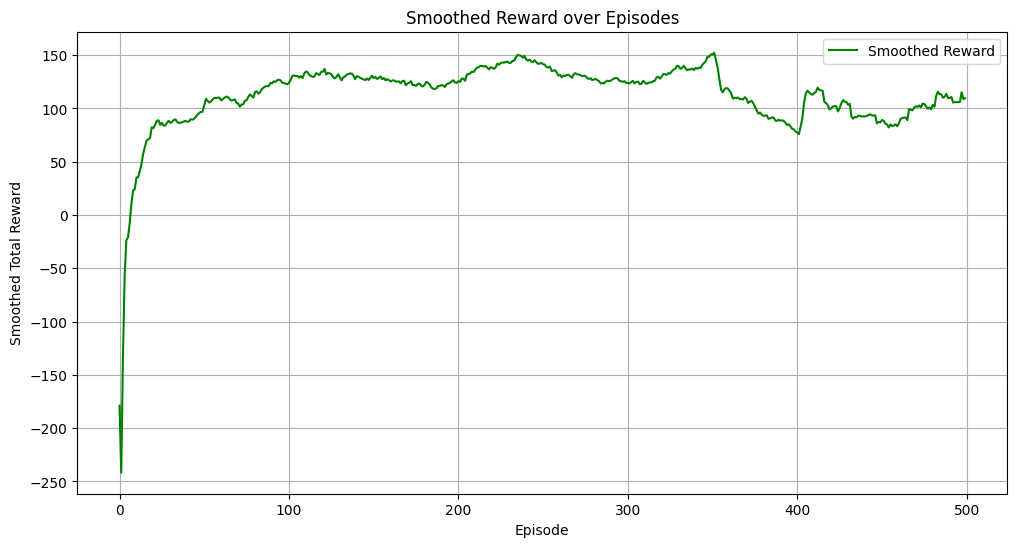

In [6]:
def smooth_rewards(rewards_history, window_size=50):
    smoothed_rewards = []
    for i in range(len(rewards_history)):
        window_start = max(0, i - window_size + 1)
        smoothed_rewards.append(np.mean(rewards_history[window_start:i+1]))
    return smoothed_rewards

# 例如，平滑过去 50 个 episode 的奖励
smoothed_rewards = smooth_rewards(rewards_history, window_size=50)

# 绘制平滑后的奖励曲线
plt.figure(figsize=(12, 6))
plt.plot(smoothed_rewards, label="Smoothed Reward", color='green')
plt.xlabel("Episode")
plt.ylabel("Smoothed Total Reward")
plt.title("Smoothed Reward over Episodes")
plt.legend()
plt.grid()
plt.show()
